# Super Mario Bros 
Es un entorno visual, la entrada es una imagen de múltiples frames por segundo, lo que se puede usar:

* CNN (Convolutional Neural Networks): Para extraer características espaciales de las imágenes.

* CNN + RNN (LSTM): Si quieres considerar la secuencia temporal (ej. para decisiones dependientes del pasado).

* DQN (Deep Q-Network): Para entornos con acción discreta como Mario.

* Double DQN o Dueling DQN: Para mejorar la estabilidad del entrenamiento.

* Rainbow DQN: Una combinación mejorada de múltiples técnicas DQN.

Para simplificar en TF-Agents, se probara usar DQN + CNN.

# Set up

In [1]:
%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.9 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp311-cp311-linux_x86_64.whl size=535719 sha256=5601ddb564d2de60af91f00d57ea66fe2d6ac6e0d9f8579fc45e5daa99eae685
  Stored in directory: /root/.cache/pip/wheels/be/b4/5a/68b9155f1d2380af0e359c71efd4c70518555be4c2f577f1d3
Successfully built nes-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [2]:
!pip install gym-super-mario-bros==7.4.0 > /dev/null
!apt-get update > /dev/null
!apt-get install -y xvfb ffmpeg > /dev/null

import os
import random
import datetime
from collections import deque
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import imageio

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


RL Definitions
==============

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The set of
all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The set
of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to Agent.
It is what drives the Agent to learn and to change its future action. An
aggregation of rewards over multiple time steps is called **Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected return
if you start in state $s$, take an arbitrary action $a$, and then for
each future time step take the action that maximizes returns. $Q$ can be
said to stand for the "quality" of the action in a state. We try to
approximate this function.


Environment
===========

Initialize Environment
----------------------

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.


In [3]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Preprocess Environment
======================

Environment data is returned to the agent in `next_state`. As you saw
above, each state is represented by a `[3, 240, 256]` size array. Often
that is more information than our agent needs; for instance, Mario's
actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

`GrayScaleObservation` is a common wrapper to transform an RGB image to
grayscale; doing so reduces the size of the state representation without
losing useful information. Now the size of each state: `[1, 240, 256]`

`ResizeObservation` downsamples each observation into a square image.
New size: `[1, 84, 84]`

`SkipFrame` is a custom wrapper that inherits from `gym.Wrapper` and
implements the `step()` function. Because consecutive frames don't vary
much, we can skip n-intermediate frames without losing much information.
The n-th frame aggregates rewards accumulated over each skipped frame.

`FrameStack` is a wrapper that allows us to squash consecutive frames of
the environment into a single observation point to feed to our learning
model. This way, we can identify if Mario was landing or jumping based
on the direction of his movement in the previous several frames.


In [4]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float) /255.0
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        if observation.shape[0] == 3:
            transform = T.Grayscale()
            observation = transform(observation)
        return observation

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True)]#, T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

Agent
=====

We create a class `Mario` to represent our agent in the game. Mario
should be able to:

-   **Act** according to the optimal action policy based on the current
    state (of the environment).
-   **Remember** experiences. Experience = (current state, current
    action, reward, next state). Mario *caches* and later *recalls* his
    experiences to update his action policy.
-   **Learn** a better action policy over time


In [5]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

Neural Network
--------------

In [6]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        self.memory.append((state, next_state, action, reward, done))

    
    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(np.array, zip(*batch))

        state = torch.tensor(state).to(self.device)
        next_state = torch.tensor(next_state).to(self.device)
        action = torch.tensor(action).to(self.device)
        reward = torch.tensor(reward).to(self.device)
        done = torch.tensor(done).to(self.device)
        return state, next_state, action, reward, done

Act
===

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of `self.exploration_rate`; when
he chooses to exploit, he relies on `MarioNet` (implemented in `Learn`
section) to provide the most optimal action.


In [7]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

Cache and Recall
================

These two functions serve as Mario's "memory" process.

`cache()`: Each time Mario performs an action, he stores the
`experience` to his memory. His experience includes the current *state*,
*action* performed, *reward* from the action, the *next state*, and
whether the game is *done*.

`recall()`: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.


In [8]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

In [9]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.net = MarioNet(self.state_dim, self.action_dim).float().to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

        self.exploration_rate = 1.0
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0
        self.save_every = 5e5

        self.memory = deque(maxlen=100000)
        self.batch_size = 32
        self.gamma = 0.9

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(self.action_dim)
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action = torch.argmax(action_values, axis=1).item()

        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.curr_step += 1
        return action

    def cache(self, state, next_state, action, reward, done):
        def extract(x):
            return x[0] if isinstance(x, tuple) else x

        state = torch.tensor(extract(state).__array__())
        next_state = torch.tensor(extract(next_state).__array__())
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])
        self.memory.append((state, next_state, action, reward, done))

    def recall(self):
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state.to(self.device), next_state.to(self.device), action.squeeze().to(self.device), reward.squeeze().to(self.device), done.squeeze().to(self.device)

    def td_estimate(self, state, action):
        return self.net(state, model="online")[np.arange(0, self.batch_size), action]

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_Q = self.net(next_state, model="target")
        best_action = torch.argmax(next_Q, axis=1)
        target_Q = self.net(next_state, model="target")[np.arange(0, self.batch_size), best_action]
        return reward + (1 - done.float()) * self.gamma * target_Q

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

    def learn(self):
        if len(self.memory) < self.batch_size:
            return None
        state, next_state, action, reward, done = self.recall()
        td_est = self.td_estimate(state, action)
        td_tgt = self.td_target(reward, next_state, done)
        loss = self.update_Q_online(td_est, td_tgt)
        return loss

    def save(self):
        save_path = self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        torch.save(dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), save_path)
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

Learn
=====

Mario uses the [DDQN algorithm](https://arxiv.org/pdf/1509.06461) under
the hood. DDQN uses two ConvNets - $Q_{online}$ and $Q_{target}$ - that
independently approximate the optimal action-value function.

In our implementation, we share feature generator `features` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC classifiers for
each. $\theta_{target}$ (the parameters of $Q_{target}$) is frozen to
prevent updating by backprop. Instead, it is periodically synced with
$\theta_{online}$ (more on this later).


TD Estimate & TD Target
=======================

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state $s$

$${TD}_e = Q_{online}^*(s,a)$$

**TD Target** - aggregation of current reward and the estimated $Q^*$ in
the next state $s'$

$$a' = argmax_{a} Q_{online}(s', a)$$

$${TD}_t = r + \gamma Q_{target}^*(s',a')$$

Because we don't know what next action $a'$ will be, we use the action
$a'$ maximizes $Q_{online}$ in the next state $s'$.

Notice we use the
[\@torch.no\_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)
decorator on `td_target()` to disable gradient calculations here
(because we don't need to backpropagate on $\theta_{target}$).


In [10]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

Updating the model
==================

As Mario samples inputs from his replay buffer, we compute $TD_t$ and
$TD_e$ and backpropagate this loss down $Q_{online}$ to update its
parameters $\theta_{online}$ ($\alpha$ is the learning rate `lr` passed
to the `optimizer`)

$$\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)$$

$\theta_{target}$ does not update through backpropagation. Instead, we
periodically copy $\theta_{online}$ to $\theta_{target}$

$$\theta_{target} \leftarrow \theta_{online}$$


In [11]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

Save checkpoint
===============


In [12]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

Putting it all together
=======================


In [13]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

# Trained Loop

In [14]:
def train(env, agent, num_episodes):
    ep_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.cache(state, next_state, action, reward, done)
            agent.learn()
            state = next_state
            total_reward += reward

            if done or truncated:
                break
        
        ep_rewards.append(total_reward)
        if episode % 10 == 0:
            print(f"Episode {episode}, reward: {total_reward}")
            agent.save()
    
    return ep_rewards

In [15]:
from pathlib import Path

save_dir = Path("checkpoints")
save_dir.mkdir(exist_ok=True)

mario = Mario(
    state_dim=env.observation_space.shape,
    action_dim=env.action_space.n,
    save_dir=save_dir
)

In [16]:
ep_rewards = train(env, mario, num_episodes=500)

Episode 0, reward: 888.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 950
Episode 10, reward: 626.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 2402
Episode 20, reward: 987.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 4883
Episode 30, reward: 217.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 7214
Episode 40, reward: 1005.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 9456
Episode 50, reward: 683.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 11764
Episode 60, reward: 807.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 14465
Episode 70, reward: 986.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 16275
Episode 80, reward: 626.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 18788
Episode 90, reward: 1029.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 22283
Episode 100, reward: 627.0
MarioNet saved to checkpoints/mario_net_0.chkpt at step 24324
Episode 110, reward: 606.0
MarioNet 

Logging
=======

In [17]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

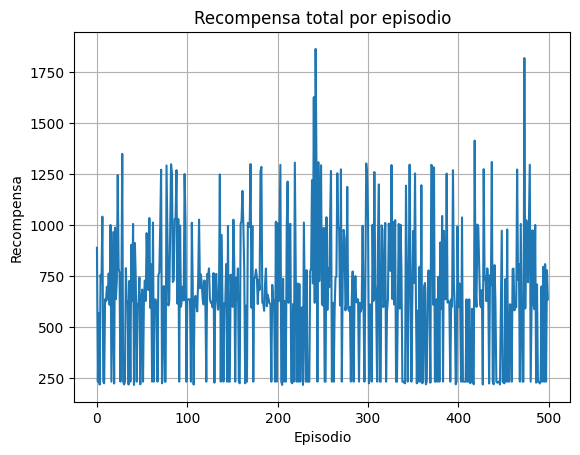

In [18]:
import matplotlib.pyplot as plt

plt.plot(ep_rewards)
plt.title("Recompensa total por episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()

# Record episode

In [19]:
def record_episode(env, policy_fn, filename, max_steps=5000):
    import imageio
    frames = []
    state = env.reset()
    for _ in range(max_steps):
        action = policy_fn(state)
        state, reward, done, truncated, info = env.step(action)
        frame = env.render(mode='rgb_array')  # for headless envs
        frames.append(frame)
        if done or truncated:
            break
    imageio.mimsave(filename, frames, fps=30)
    print(f"Video saved: {filename}")

In [20]:
# Antes del entrenamiento
record_episode(env, lambda s: env.action_space.sample(), "random_policy.mp4")

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


Video saved: random_policy.mp4


In [21]:
# Después del entrenamiento
mario.exploration_rate = 0.0
record_episode(env, lambda s: mario.act(s), "trained_policy.mp4")

Video saved: trained_policy.mp4
